In [224]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import mean_squared_error, r2_score


ERROR! Session/line number was not unique in database. History logging moved to new session 177


In [13]:
print("Num GPUs avaliable: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Keras Version " + keras.__version__)
print("TF Version " + tf.__version__)
print("Numpy Version " + np.__version__)
print("Pandas Version " + pd.__version__)
print("Matplotlib Version " + matplotlib.__version__)
print("Seaborn Version " + sns.__version__)
print("Scikit Version " + sklearn.__version__)

'''
Num GPUs avaliable:  1
Keras Version 2.3.1
TF Version 2.1.0
Numpy Version 1.19.2
Pandas Version 1.1.3
Matplotlib Version 3.2.2
Seaborn Version 0.11.0
Scikit Version 0.23.2
'''

Num GPUs avaliable:  1
Keras Version 2.3.1
TF Version 2.1.0
Numpy Version 1.19.2
Pandas Version 1.1.3
Matplotlib Version 3.2.2
Seaborn Version 0.11.0
Scikit Version 0.23.2


In [14]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15586931260745771625
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3138361755
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7177494962361137156
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [196]:
#Importing the Dataset
dataset = pd.read_csv('2021_10_31_cleaned_lake_dataset_with_tds.csv', header=0, index_col=0)
dataset = dataset.rename(columns={'actual_conductivity':'cond', 'total_dissolved_solids':'tds', 'do_concentration':'do', 'turbidity':'turb', 'chl-a_concentration':'chl-a', 'temperature':'temp'})
dataset = dataset[['temp', 'cond', 'do', 'tds', 'turb', 'chl-a']]
dataset.sort_index()
dataset.head()

,temp,cond,do,tds,turb,chl-a
datetime,,,,,,
2019-02-20 12:00:00,29.55674,92.12651,6.491213,0.055088,32.86783,39.64875
2019-02-20 12:10:00,29.59175,92.22813,6.724226,0.055115,24.30492,40.57396
2019-02-20 12:20:00,29.57693,91.93182,6.677357,0.054952,47.46174,40.88269
2019-02-20 12:30:00,29.63118,92.45161,7.540924,0.055210,55.04100,46.67803
2019-02-20 12:40:00,29.64378,92.78736,7.629431,0.055398,26.58170,47.05107


In [56]:
#Data Preprocessing

#Trying on both trimmed and untrimmed
trimmed_dataset = dataset[:] #['2019-02-20' : '2019-04-05'] #
trimmed_dataset.tail()
print("Trimmed dataset shape: " + str(trimmed_dataset.shape))

#Ascertain all data is float
values = trimmed_dataset.values

values = values.astype('float32')

#Normalizing Features
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values)
# scaled_df = pd.DataFrame(scaled_data)
# scaled_df.tail()
print("Scaled dataset shape: " + str(values.shape))

Trimmed dataset shape: (8516, 6)
Scaled dataset shape: (8516, 6)


In [197]:
#Data Random Split #TYPE2
dataset = dataset['2019-03-05' : '2019-09-12']  #['2019-02-20' : '2019-03-21']#
train_dataset_rand = dataset.sample(frac=0.8) #80% split
test_dataset_rand = dataset.drop(train_dataset_rand.index)
train_labels_rand = train_dataset_rand.pop('chl-a')
test_labels_rand = test_dataset_rand.pop('chl-a')
dataset.tail()

,temp,cond,do,tds,turb,chl-a
datetime,,,,,,
2019-04-05 09:00:17,28.91959,76.91243,3.080355,0.046511,63.40566,49.60603
2019-04-05 09:10:17,28.94431,76.73137,3.062878,0.046381,72.05052,47.30184
2019-04-05 09:20:17,28.93608,76.69234,2.589782,0.046364,63.05659,44.22813
2019-04-05 09:30:17,28.94136,76.72667,2.999108,0.046381,80.66748,45.35073
2019-04-05 09:40:17,28.96102,76.72181,3.165897,0.046362,68.04305,44.16881


In [198]:
print(train_dataset_rand.shape)
train_dataset_rand.head()

(3538, 5)


,temp,cond,do,tds,turb
datetime,,,,,
2019-03-11 01:18:05,28.84898,84.21928,4.715853,0.050994,60.40948
2019-03-15 05:43:32,30.35499,92.04287,7.647199,0.054276,39.81909
2019-03-31 21:23:09,30.16802,94.84049,2.804431,0.056108,87.99799
2019-03-25 20:54:44,30.10338,94.96810,3.693730,0.056247,83.02825
2019-04-02 22:03:09,29.53305,80.36359,3.730003,0.048074,115.69180


In [199]:
print(test_dataset_rand.shape)
test_dataset_rand.head()

(884, 5)


,temp,cond,do,tds,turb
datetime,,,,,
2019-03-05 01:07:54,30.51098,99.75539,5.421569,0.058666,57.53459
2019-03-05 01:17:54,30.43110,99.93394,4.478407,0.058852,64.37251
2019-03-05 02:57:54,30.51418,99.39680,5.823132,0.058452,50.11823
2019-03-05 04:47:54,30.61272,99.63879,7.625192,0.058494,48.84952
2019-03-05 06:17:54,30.46802,99.52344,7.025146,0.058573,53.23996


In [200]:
#Dataset Stats
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,4422.0,30.231713,0.643074,28.474770,29.965780,30.353445,30.686343,31.595630
cond,4422.0,94.327866,7.148516,71.087590,92.324223,95.181790,98.935115,108.500900
do,4422.0,5.449614,2.363044,0.115000,3.509775,5.241186,7.209045,12.579920
tds,4422.0,0.055712,0.003793,0.042957,0.054559,0.056151,0.058057,0.063784
turb,4422.0,74.674486,57.868262,9.632318,32.284795,59.107145,92.321070,272.187000
chl-a,4422.0,189.429200,112.356938,44.168810,67.110095,196.116650,297.943525,432.326500


In [201]:
#Normalize random data
train_rand_val = train_dataset_rand.values
test_rand_val = test_dataset_rand.values
scaler = MinMaxScaler(feature_range=(-1,1))

scaled_train_rand = scaler.fit_transform(train_rand_val)
scaled_test_rand = scaler.fit_transform(test_rand_val)

print(scaled_train_rand.shape)
print(scaled_test_rand.shape)
print(len(train_dataset_rand.keys()))

(3538, 5)
(884, 5)
5


In [70]:
n_train = int(0.8*np.ceil(float(scaled_data.shape[0]))) #80%

train = scaled_data[:n_train, :]
test = scaled_data[n_train:,:]

train_X = train[:,:-1]
train_y = train[:,-1]

test_X = test[:,:-1]
test_y = test[:,-1]

# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6812, 5) (6812,) (1704, 5) (1704,)


In [209]:
# Create model
#, kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)
model = Sequential()
model.add(Dense(32, kernel_initializer= 'normal', input_dim=5, activation="tanh"))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer= 'normal', activation="sigmoid"))
#model.add(Dropout(0.2))
model.add(Dense(8, kernel_initializer= 'normal', activation="tanh"))
#model.add(Dropout(0.2))

# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mae', optimizer= 'adam', metrics=['mae', 'mse']) #Adam(lr=1e-3, decay=1e-3 / 200) 'adam'

# Patient early stopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 32)                192       
_________________________________________________________________
dense_120 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_121 (Dense)            (None, 8)                 520       
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 9         
Total params: 2,833
Trainable params: 2,833
Non-trainable params: 0
_________________________________________________________________


In [210]:
#Early stop
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

# Fit the model
#history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=1000, batch_size=128, verbose=2, shuffle=True, callbacks=[early_stop]) #, callbacks=[es]

#Fit model with rand dataset
history = model.fit(scaled_train_rand, train_labels_rand, validation_data=(scaled_test_rand, test_labels_rand), epochs=10000, batch_size=128, verbose=2, shuffle=True, callbacks=[early_stop])

# # Calculate predictions
# PredTestSet = model.predict(train_X)
# PredValSet = model.predict(test_X)

# # Save predictions
# np.savetxt("trainresults.csv", PredTestSet, delimiter=",")
# np.savetxt("valresults.csv", PredValSet, delimiter=",")



Train on 3538 samples, validate on 884 samples
Epoch 1/10000
 - 0s - loss: 187.0328 - mae: 187.0328 - mse: 47644.0703 - val_loss: 188.9719 - val_mae: 188.9719 - val_mse: 48179.9336
Epoch 2/10000
 - 0s - loss: 185.6003 - mae: 185.6003 - mse: 47107.1914 - val_loss: 188.1678 - val_mae: 188.1678 - val_mse: 47876.1406
Epoch 3/10000
 - 0s - loss: 185.0298 - mae: 185.0298 - mse: 46893.9414 - val_loss: 187.7530 - val_mae: 187.7530 - val_mse: 47719.6172
Epoch 4/10000
 - 0s - loss: 184.6684 - mae: 184.6684 - mse: 46760.2812 - val_loss: 187.4305 - val_mae: 187.4305 - val_mse: 47598.5195
Epoch 5/10000
 - 0s - loss: 184.3617 - mae: 184.3617 - mse: 46646.5586 - val_loss: 187.1367 - val_mae: 187.1367 - val_mse: 47488.6523
Epoch 6/10000
 - 0s - loss: 184.0745 - mae: 184.0746 - mse: 46540.9414 - val_loss: 186.8554 - val_mae: 186.8554 - val_mse: 47383.5781
Epoch 7/10000
 - 0s - loss: 183.7967 - mae: 183.7967 - mse: 46439.3008 - val_loss: 186.5809 - val_mae: 186.5809 - val_mse: 47281.1367
Epoch 8/10000
 

Epoch 62/10000
 - 0s - loss: 169.7235 - mae: 169.7235 - mse: 41463.9180 - val_loss: 172.5187 - val_mae: 172.5187 - val_mse: 42231.4922
Epoch 63/10000
 - 0s - loss: 169.4707 - mae: 169.4707 - mse: 41377.8828 - val_loss: 172.2660 - val_mae: 172.2660 - val_mse: 42144.3594
Epoch 64/10000
 - 0s - loss: 169.2180 - mae: 169.2180 - mse: 41291.9336 - val_loss: 172.0133 - val_mae: 172.0133 - val_mse: 42057.3633
Epoch 65/10000
 - 0s - loss: 168.9653 - mae: 168.9653 - mse: 41207.2461 - val_loss: 171.7606 - val_mae: 171.7606 - val_mse: 41970.4961
Epoch 66/10000
 - 0s - loss: 168.7127 - mae: 168.7127 - mse: 41121.8320 - val_loss: 171.5080 - val_mae: 171.5079 - val_mse: 41883.7656
Epoch 67/10000
 - 0s - loss: 168.4600 - mae: 168.4600 - mse: 41036.3906 - val_loss: 171.2553 - val_mae: 171.2553 - val_mse: 41797.1719
Epoch 68/10000
 - 0s - loss: 168.2074 - mae: 168.2074 - mse: 40951.4453 - val_loss: 171.0027 - val_mae: 171.0027 - val_mse: 41710.7109
Epoch 69/10000
 - 0s - loss: 167.9548 - mae: 167.9548 -

Epoch 123/10000
 - 0s - loss: 154.3313 - mae: 154.3313 - mse: 36475.7812 - val_loss: 157.1269 - val_mae: 157.1269 - val_mse: 37157.6562
Epoch 124/10000
 - 0s - loss: 154.0792 - mae: 154.0792 - mse: 36398.1602 - val_loss: 156.8748 - val_mae: 156.8748 - val_mse: 37078.4922
Epoch 125/10000
 - 0s - loss: 153.8271 - mae: 153.8271 - mse: 36320.3203 - val_loss: 156.6227 - val_mae: 156.6227 - val_mse: 36999.4609
Epoch 126/10000
 - 0s - loss: 153.5750 - mae: 153.5750 - mse: 36242.5039 - val_loss: 156.3706 - val_mae: 156.3706 - val_mse: 36920.5547
Epoch 127/10000
 - 0s - loss: 153.3229 - mae: 153.3229 - mse: 36165.1016 - val_loss: 156.1185 - val_mae: 156.1185 - val_mse: 36841.7812
Epoch 128/10000
 - 0s - loss: 153.0708 - mae: 153.0709 - mse: 36088.3906 - val_loss: 155.8664 - val_mae: 155.8664 - val_mse: 36763.1328
Epoch 129/10000
 - 0s - loss: 152.8187 - mae: 152.8187 - mse: 36011.4141 - val_loss: 155.6143 - val_mae: 155.6144 - val_mse: 36684.6133
Epoch 130/10000
 - 0s - loss: 152.5666 - mae: 15

Epoch 184/10000
 - 0s - loss: 139.1200 - mae: 139.1200 - mse: 31987.2559 - val_loss: 141.9022 - val_mae: 141.9022 - val_mse: 32584.9590
Epoch 185/10000
 - 0s - loss: 138.8916 - mae: 138.8916 - mse: 31919.6699 - val_loss: 141.6716 - val_mae: 141.6716 - val_mse: 32516.9004
Epoch 186/10000
 - 0s - loss: 138.6649 - mae: 138.6649 - mse: 31853.0918 - val_loss: 141.4420 - val_mae: 141.4420 - val_mse: 32448.8594
Epoch 187/10000
 - 0s - loss: 138.4393 - mae: 138.4393 - mse: 31787.0098 - val_loss: 141.2150 - val_mae: 141.2150 - val_mse: 32381.1895
Epoch 188/10000
 - 0s - loss: 138.2158 - mae: 138.2158 - mse: 31720.5605 - val_loss: 140.9901 - val_mae: 140.9901 - val_mse: 32313.7734
Epoch 189/10000
 - 0s - loss: 137.9939 - mae: 137.9939 - mse: 31654.9531 - val_loss: 140.7670 - val_mae: 140.7670 - val_mse: 32246.7168
Epoch 190/10000
 - 0s - loss: 137.7735 - mae: 137.7735 - mse: 31589.5098 - val_loss: 140.5479 - val_mae: 140.5479 - val_mse: 32180.3340
Epoch 191/10000
 - 0s - loss: 137.5558 - mae: 13

Epoch 245/10000
 - 0s - loss: 128.7984 - mae: 128.7984 - mse: 28507.0723 - val_loss: 131.2602 - val_mae: 131.2602 - val_mse: 29038.3906
Epoch 246/10000
 - 0s - loss: 128.6860 - mae: 128.6860 - mse: 28459.0742 - val_loss: 131.1362 - val_mae: 131.1362 - val_mse: 28989.0469
Epoch 247/10000
 - 0s - loss: 128.5741 - mae: 128.5741 - mse: 28411.3711 - val_loss: 131.0153 - val_mae: 131.0153 - val_mse: 28940.8105
Epoch 248/10000
 - 0s - loss: 128.4646 - mae: 128.4646 - mse: 28364.2422 - val_loss: 130.8951 - val_mae: 130.8951 - val_mse: 28892.2656
Epoch 249/10000
 - 0s - loss: 128.3563 - mae: 128.3563 - mse: 28317.0566 - val_loss: 130.7777 - val_mae: 130.7777 - val_mse: 28844.5410
Epoch 250/10000
 - 0s - loss: 128.2500 - mae: 128.2500 - mse: 28269.9980 - val_loss: 130.6604 - val_mae: 130.6604 - val_mse: 28796.7539
Epoch 251/10000
 - 0s - loss: 128.1452 - mae: 128.1452 - mse: 28223.3633 - val_loss: 130.5425 - val_mae: 130.5425 - val_mse: 28748.6562
Epoch 252/10000
 - 0s - loss: 128.0405 - mae: 12

Epoch 306/10000
 - 0s - loss: 121.5919 - mae: 121.5920 - mse: 25558.6914 - val_loss: 123.8123 - val_mae: 123.8123 - val_mse: 26023.3945
Epoch 307/10000
 - 0s - loss: 121.4974 - mae: 121.4974 - mse: 25509.2637 - val_loss: 123.7034 - val_mae: 123.7034 - val_mse: 25972.1035
Epoch 308/10000
 - 0s - loss: 121.3841 - mae: 121.3841 - mse: 25459.6133 - val_loss: 123.5878 - val_mae: 123.5878 - val_mse: 25921.3320
Epoch 309/10000
 - 0s - loss: 121.2766 - mae: 121.2766 - mse: 25410.2793 - val_loss: 123.4777 - val_mae: 123.4777 - val_mse: 25871.1289
Epoch 310/10000
 - 0s - loss: 121.1715 - mae: 121.1715 - mse: 25360.8516 - val_loss: 123.3659 - val_mae: 123.3659 - val_mse: 25820.3535
Epoch 311/10000
 - 0s - loss: 121.0720 - mae: 121.0720 - mse: 25311.4961 - val_loss: 123.2527 - val_mae: 123.2527 - val_mse: 25769.3398
Epoch 312/10000
 - 0s - loss: 120.9658 - mae: 120.9658 - mse: 25262.6719 - val_loss: 123.1438 - val_mae: 123.1438 - val_mse: 25720.3008
Epoch 313/10000
 - 0s - loss: 120.8611 - mae: 12

Epoch 367/10000
 - 0s - loss: 115.4604 - mae: 115.4604 - mse: 22609.0859 - val_loss: 117.3092 - val_mae: 117.3092 - val_mse: 22997.9395
Epoch 368/10000
 - 0s - loss: 115.3532 - mae: 115.3532 - mse: 22561.3906 - val_loss: 117.2140 - val_mae: 117.2140 - val_mse: 22948.7148
Epoch 369/10000
 - 0s - loss: 115.2583 - mae: 115.2583 - mse: 22513.9375 - val_loss: 117.1012 - val_mae: 117.1012 - val_mse: 22900.0176
Epoch 370/10000
 - 0s - loss: 115.1711 - mae: 115.1711 - mse: 22466.8984 - val_loss: 117.0274 - val_mae: 117.0275 - val_mse: 22852.2227
Epoch 371/10000
 - 0s - loss: 115.0743 - mae: 115.0743 - mse: 22419.4219 - val_loss: 116.9120 - val_mae: 116.9120 - val_mse: 22802.3574
Epoch 372/10000
 - 0s - loss: 114.9628 - mae: 114.9628 - mse: 22371.6230 - val_loss: 116.7958 - val_mae: 116.7958 - val_mse: 22753.8906
Epoch 373/10000
 - 0s - loss: 114.8619 - mae: 114.8619 - mse: 22324.3867 - val_loss: 116.6868 - val_mae: 116.6868 - val_mse: 22704.0410
Epoch 374/10000
 - 0s - loss: 114.7564 - mae: 11

Epoch 428/10000
 - 0s - loss: 109.0851 - mae: 109.0851 - mse: 19757.7617 - val_loss: 110.7853 - val_mae: 110.7853 - val_mse: 20063.0332
Epoch 429/10000
 - 0s - loss: 108.9842 - mae: 108.9841 - mse: 19713.2441 - val_loss: 110.6438 - val_mae: 110.6438 - val_mse: 20016.8242
Epoch 430/10000
 - 0s - loss: 108.8801 - mae: 108.8801 - mse: 19669.2891 - val_loss: 110.5441 - val_mae: 110.5441 - val_mse: 19970.9766
Epoch 431/10000
 - 0s - loss: 108.7740 - mae: 108.7740 - mse: 19625.2168 - val_loss: 110.4401 - val_mae: 110.4401 - val_mse: 19926.4863
Epoch 432/10000
 - 0s - loss: 108.6772 - mae: 108.6772 - mse: 19581.4102 - val_loss: 110.3333 - val_mae: 110.3333 - val_mse: 19880.6055
Epoch 433/10000
 - 0s - loss: 108.5791 - mae: 108.5791 - mse: 19537.9688 - val_loss: 110.2304 - val_mae: 110.2304 - val_mse: 19835.8828
Epoch 434/10000
 - 0s - loss: 108.4775 - mae: 108.4774 - mse: 19494.6523 - val_loss: 110.1493 - val_mae: 110.1493 - val_mse: 19793.0898
Epoch 435/10000
 - 0s - loss: 108.3798 - mae: 10

Epoch 489/10000
 - 0s - loss: 103.5665 - mae: 103.5665 - mse: 17306.4141 - val_loss: 105.0379 - val_mae: 105.0379 - val_mse: 17531.1152
Epoch 490/10000
 - 0s - loss: 103.4806 - mae: 103.4806 - mse: 17269.7129 - val_loss: 104.9659 - val_mae: 104.9659 - val_mse: 17493.4785
Epoch 491/10000
 - 0s - loss: 103.4044 - mae: 103.4044 - mse: 17233.4512 - val_loss: 104.8657 - val_mae: 104.8657 - val_mse: 17455.7637
Epoch 492/10000
 - 0s - loss: 103.3082 - mae: 103.3082 - mse: 17196.8418 - val_loss: 104.7537 - val_mae: 104.7537 - val_mse: 17417.6328
Epoch 493/10000
 - 0s - loss: 103.2300 - mae: 103.2300 - mse: 17160.2812 - val_loss: 104.6768 - val_mae: 104.6768 - val_mse: 17378.7188
Epoch 494/10000
 - 0s - loss: 103.1446 - mae: 103.1446 - mse: 17123.4004 - val_loss: 104.5929 - val_mae: 104.5929 - val_mse: 17341.9453
Epoch 495/10000
 - 0s - loss: 103.0635 - mae: 103.0634 - mse: 17087.6973 - val_loss: 104.5009 - val_mae: 104.5009 - val_mse: 17303.6484
Epoch 496/10000
 - 0s - loss: 102.9796 - mae: 10

Epoch 550/10000
 - 0s - loss: 98.5558 - mae: 98.5558 - mse: 15168.2275 - val_loss: 99.6378 - val_mae: 99.6378 - val_mse: 15306.5312
Epoch 551/10000
 - 0s - loss: 98.4685 - mae: 98.4685 - mse: 15137.0234 - val_loss: 99.5372 - val_mae: 99.5372 - val_mse: 15269.9141
Epoch 552/10000
 - 0s - loss: 98.3935 - mae: 98.3935 - mse: 15103.7119 - val_loss: 99.4691 - val_mae: 99.4691 - val_mse: 15238.5811
Epoch 553/10000
 - 0s - loss: 98.3125 - mae: 98.3125 - mse: 15069.9336 - val_loss: 99.3593 - val_mae: 99.3593 - val_mse: 15201.5098
Epoch 554/10000
 - 0s - loss: 98.2340 - mae: 98.2340 - mse: 15041.0293 - val_loss: 99.2706 - val_mae: 99.2706 - val_mse: 15166.5918
Epoch 555/10000
 - 0s - loss: 98.1503 - mae: 98.1503 - mse: 15002.9688 - val_loss: 99.1778 - val_mae: 99.1778 - val_mse: 15133.5137
Epoch 556/10000
 - 0s - loss: 98.0523 - mae: 98.0523 - mse: 14971.0840 - val_loss: 99.0850 - val_mae: 99.0850 - val_mse: 15098.5146
Epoch 557/10000
 - 0s - loss: 97.9685 - mae: 97.9685 - mse: 14939.8936 - val

 - 0s - loss: 93.3522 - mae: 93.3522 - mse: 13273.6436 - val_loss: 94.0507 - val_mae: 94.0507 - val_mse: 13318.3066
Epoch 613/10000
 - 0s - loss: 93.2692 - mae: 93.2692 - mse: 13244.4746 - val_loss: 93.9611 - val_mae: 93.9611 - val_mse: 13290.0830
Epoch 614/10000
 - 0s - loss: 93.1913 - mae: 93.1913 - mse: 13215.7979 - val_loss: 93.8678 - val_mae: 93.8678 - val_mse: 13259.8311
Epoch 615/10000
 - 0s - loss: 93.1147 - mae: 93.1147 - mse: 13191.3125 - val_loss: 93.7687 - val_mae: 93.7687 - val_mse: 13230.7100
Epoch 616/10000
 - 0s - loss: 93.0268 - mae: 93.0268 - mse: 13161.4971 - val_loss: 93.7010 - val_mae: 93.7010 - val_mse: 13204.3623
Epoch 617/10000
 - 0s - loss: 92.9504 - mae: 92.9504 - mse: 13135.9277 - val_loss: 93.6338 - val_mae: 93.6338 - val_mse: 13174.3457
Epoch 618/10000
 - 0s - loss: 92.8798 - mae: 92.8798 - mse: 13107.3213 - val_loss: 93.5451 - val_mae: 93.5451 - val_mse: 13148.8545
Epoch 619/10000
 - 0s - loss: 92.7994 - mae: 92.7994 - mse: 13080.9150 - val_loss: 93.4479 -

Epoch 675/10000
 - 0s - loss: 88.6913 - mae: 88.6913 - mse: 11729.7393 - val_loss: 88.9586 - val_mae: 88.9586 - val_mse: 11689.3584
Epoch 676/10000
 - 0s - loss: 88.6225 - mae: 88.6224 - mse: 11708.7656 - val_loss: 88.8779 - val_mae: 88.8779 - val_mse: 11666.5449
Epoch 677/10000
 - 0s - loss: 88.5483 - mae: 88.5483 - mse: 11687.4209 - val_loss: 88.8138 - val_mae: 88.8138 - val_mse: 11643.6191
Epoch 678/10000
 - 0s - loss: 88.4776 - mae: 88.4777 - mse: 11666.7754 - val_loss: 88.7656 - val_mae: 88.7656 - val_mse: 11622.1660
Epoch 679/10000
 - 0s - loss: 88.4173 - mae: 88.4173 - mse: 11645.5830 - val_loss: 88.7150 - val_mae: 88.7150 - val_mse: 11599.7197
Epoch 680/10000
 - 0s - loss: 88.3515 - mae: 88.3515 - mse: 11624.0186 - val_loss: 88.5793 - val_mae: 88.5793 - val_mse: 11575.8916
Epoch 681/10000
 - 0s - loss: 88.2829 - mae: 88.2829 - mse: 11604.0527 - val_loss: 88.5238 - val_mae: 88.5238 - val_mse: 11554.8457
Epoch 682/10000
 - 0s - loss: 88.2085 - mae: 88.2085 - mse: 11581.6914 - val

 - 0s - loss: 84.6958 - mae: 84.6958 - mse: 10564.6904 - val_loss: 84.7055 - val_mae: 84.7055 - val_mse: 10437.5928
Epoch 738/10000
 - 0s - loss: 84.6384 - mae: 84.6384 - mse: 10547.7393 - val_loss: 84.6311 - val_mae: 84.6311 - val_mse: 10420.6738
Epoch 739/10000
 - 0s - loss: 84.5711 - mae: 84.5711 - mse: 10532.5977 - val_loss: 84.6186 - val_mae: 84.6186 - val_mse: 10403.7422
Epoch 740/10000
 - 0s - loss: 84.5082 - mae: 84.5082 - mse: 10516.6768 - val_loss: 84.5339 - val_mae: 84.5339 - val_mse: 10386.1123
Epoch 741/10000
 - 0s - loss: 84.4443 - mae: 84.4443 - mse: 10500.3535 - val_loss: 84.4605 - val_mae: 84.4605 - val_mse: 10369.6973
Epoch 742/10000
 - 0s - loss: 84.4188 - mae: 84.4188 - mse: 10486.3848 - val_loss: 84.4089 - val_mae: 84.4089 - val_mse: 10351.9229
Epoch 743/10000
 - 0s - loss: 84.3522 - mae: 84.3522 - mse: 10470.0410 - val_loss: 84.3577 - val_mae: 84.3577 - val_mse: 10334.4551
Epoch 744/10000
 - 0s - loss: 84.2826 - mae: 84.2826 - mse: 10453.5557 - val_loss: 84.2329 -

Epoch 800/10000
 - 0s - loss: 80.9351 - mae: 80.9351 - mse: 9696.1387 - val_loss: 80.5226 - val_mae: 80.5226 - val_mse: 9480.9922
Epoch 801/10000
 - 0s - loss: 80.8987 - mae: 80.8987 - mse: 9683.6611 - val_loss: 80.5615 - val_mae: 80.5615 - val_mse: 9466.0391
Epoch 802/10000
 - 0s - loss: 80.8431 - mae: 80.8431 - mse: 9674.7783 - val_loss: 80.4596 - val_mae: 80.4596 - val_mse: 9454.4053
Epoch 803/10000
 - 0s - loss: 80.7621 - mae: 80.7621 - mse: 9661.6064 - val_loss: 80.3353 - val_mae: 80.3353 - val_mse: 9444.8408
Epoch 804/10000
 - 0s - loss: 80.6984 - mae: 80.6984 - mse: 9648.9961 - val_loss: 80.2448 - val_mae: 80.2448 - val_mse: 9433.1221
Epoch 805/10000
 - 0s - loss: 80.6508 - mae: 80.6508 - mse: 9640.9912 - val_loss: 80.2024 - val_mae: 80.2024 - val_mse: 9418.7764
Epoch 806/10000
 - 0s - loss: 80.5815 - mae: 80.5815 - mse: 9628.0332 - val_loss: 80.1421 - val_mae: 80.1421 - val_mse: 9407.6523
Epoch 807/10000
 - 0s - loss: 80.5345 - mae: 80.5345 - mse: 9617.6064 - val_loss: 80.1020 

 - 0s - loss: 77.6295 - mae: 77.6295 - mse: 9150.6006 - val_loss: 76.8265 - val_mae: 76.8265 - val_mse: 8864.7881
Epoch 864/10000
 - 0s - loss: 77.5911 - mae: 77.5910 - mse: 9146.6357 - val_loss: 76.7388 - val_mae: 76.7388 - val_mse: 8855.2695
Epoch 865/10000
 - 0s - loss: 77.5583 - mae: 77.5583 - mse: 9138.8760 - val_loss: 76.7182 - val_mae: 76.7182 - val_mse: 8851.1016
Epoch 866/10000
 - 0s - loss: 77.5178 - mae: 77.5178 - mse: 9136.4961 - val_loss: 76.6861 - val_mae: 76.6861 - val_mse: 8835.4844
Epoch 867/10000
 - 0s - loss: 77.4551 - mae: 77.4551 - mse: 9125.1816 - val_loss: 76.5799 - val_mae: 76.5799 - val_mse: 8839.4053
Epoch 868/10000
 - 0s - loss: 77.4170 - mae: 77.4170 - mse: 9126.4209 - val_loss: 76.5462 - val_mae: 76.5462 - val_mse: 8829.9570
Epoch 869/10000
 - 0s - loss: 77.3727 - mae: 77.3727 - mse: 9115.9277 - val_loss: 76.4606 - val_mae: 76.4606 - val_mse: 8820.9297
Epoch 870/10000
 - 0s - loss: 77.3396 - mae: 77.3396 - mse: 9112.3359 - val_loss: 76.3924 - val_mae: 76.39

Epoch 927/10000
 - 0s - loss: 75.0956 - mae: 75.0956 - mse: 8917.0244 - val_loss: 73.9841 - val_mae: 73.9841 - val_mse: 8569.3428
Epoch 928/10000
 - 0s - loss: 75.0750 - mae: 75.0750 - mse: 8913.8418 - val_loss: 73.9061 - val_mae: 73.9061 - val_mse: 8560.6270
Epoch 929/10000
 - 0s - loss: 75.0273 - mae: 75.0273 - mse: 8917.5537 - val_loss: 73.8797 - val_mae: 73.8797 - val_mse: 8574.0566
Epoch 930/10000
 - 0s - loss: 74.9967 - mae: 74.9967 - mse: 8912.0703 - val_loss: 73.8507 - val_mae: 73.8507 - val_mse: 8550.8135
Epoch 931/10000
 - 0s - loss: 74.9592 - mae: 74.9592 - mse: 8909.4189 - val_loss: 73.7988 - val_mae: 73.7988 - val_mse: 8557.0869
Epoch 932/10000
 - 0s - loss: 74.9194 - mae: 74.9194 - mse: 8910.9893 - val_loss: 73.7993 - val_mae: 73.7993 - val_mse: 8552.6016
Epoch 933/10000
 - 0s - loss: 74.8859 - mae: 74.8859 - mse: 8903.3174 - val_loss: 73.6836 - val_mae: 73.6836 - val_mse: 8556.9482
Epoch 934/10000
 - 0s - loss: 74.8534 - mae: 74.8534 - mse: 8910.2051 - val_loss: 73.7369 

 - 0s - loss: 73.1953 - mae: 73.1953 - mse: 8933.6045 - val_loss: 71.7100 - val_mae: 71.7100 - val_mse: 8518.9209
Epoch 991/10000
 - 0s - loss: 73.1543 - mae: 73.1543 - mse: 8934.9736 - val_loss: 71.7029 - val_mae: 71.7029 - val_mse: 8517.0449
Epoch 992/10000
 - 0s - loss: 73.1253 - mae: 73.1253 - mse: 8936.2842 - val_loss: 71.7236 - val_mae: 71.7236 - val_mse: 8513.1846
Epoch 993/10000
 - 0s - loss: 73.1130 - mae: 73.1130 - mse: 8934.0391 - val_loss: 71.5914 - val_mae: 71.5914 - val_mse: 8530.6221
Epoch 994/10000
 - 0s - loss: 73.1410 - mae: 73.1410 - mse: 8941.4502 - val_loss: 71.6023 - val_mae: 71.6023 - val_mse: 8518.5039
Epoch 995/10000
 - 0s - loss: 73.0456 - mae: 73.0456 - mse: 8942.7998 - val_loss: 71.5876 - val_mae: 71.5876 - val_mse: 8521.2715
Epoch 996/10000
 - 0s - loss: 73.0298 - mae: 73.0298 - mse: 8943.8945 - val_loss: 71.4947 - val_mae: 71.4947 - val_mse: 8530.5801
Epoch 997/10000
 - 0s - loss: 73.0207 - mae: 73.0207 - mse: 8945.4189 - val_loss: 71.5375 - val_mae: 71.53

Epoch 1053/10000
 - 0s - loss: 71.7374 - mae: 71.7374 - mse: 9152.7549 - val_loss: 69.9129 - val_mae: 69.9129 - val_mse: 8661.1865
Epoch 1054/10000
 - 0s - loss: 71.7233 - mae: 71.7233 - mse: 9152.4492 - val_loss: 69.8573 - val_mae: 69.8573 - val_mse: 8676.3359
Epoch 1055/10000
 - 0s - loss: 71.6838 - mae: 71.6838 - mse: 9158.4590 - val_loss: 69.8084 - val_mae: 69.8084 - val_mse: 8677.1592
Epoch 1056/10000
 - 0s - loss: 71.6506 - mae: 71.6506 - mse: 9165.2598 - val_loss: 69.8331 - val_mae: 69.8331 - val_mse: 8681.0332
Epoch 1057/10000
 - 0s - loss: 71.6613 - mae: 71.6613 - mse: 9169.4004 - val_loss: 69.7813 - val_mae: 69.7813 - val_mse: 8684.1816
Epoch 1058/10000
 - 0s - loss: 71.6318 - mae: 71.6318 - mse: 9174.8584 - val_loss: 69.6588 - val_mae: 69.6588 - val_mse: 8698.9043
Epoch 1059/10000
 - 0s - loss: 71.6484 - mae: 71.6484 - mse: 9184.7002 - val_loss: 69.7464 - val_mae: 69.7464 - val_mse: 8689.3115
Epoch 1060/10000
 - 0s - loss: 71.6065 - mae: 71.6065 - mse: 9184.4424 - val_loss: 

Epoch 1116/10000
 - 0s - loss: 64.3010 - mae: 64.3010 - mse: 6889.2051 - val_loss: 63.3215 - val_mae: 63.3215 - val_mse: 6601.1782
Epoch 1117/10000
 - 0s - loss: 64.2043 - mae: 64.2043 - mse: 6898.1279 - val_loss: 63.6169 - val_mae: 63.6169 - val_mse: 6629.9478
Epoch 1118/10000
 - 0s - loss: 64.0464 - mae: 64.0464 - mse: 6848.6782 - val_loss: 63.0642 - val_mae: 63.0642 - val_mse: 6561.4976
Epoch 1119/10000
 - 0s - loss: 63.9990 - mae: 63.9990 - mse: 6848.5459 - val_loss: 63.2818 - val_mae: 63.2818 - val_mse: 6572.4976
Epoch 1120/10000
 - 0s - loss: 63.8257 - mae: 63.8257 - mse: 6820.7744 - val_loss: 62.9442 - val_mae: 62.9442 - val_mse: 6532.6035
Epoch 1121/10000
 - 0s - loss: 63.7275 - mae: 63.7275 - mse: 6802.9141 - val_loss: 62.9321 - val_mae: 62.9321 - val_mse: 6516.5571
Epoch 1122/10000
 - 0s - loss: 63.5994 - mae: 63.5994 - mse: 6773.7969 - val_loss: 62.7877 - val_mae: 62.7877 - val_mse: 6492.5649
Epoch 1123/10000
 - 0s - loss: 63.5168 - mae: 63.5169 - mse: 6760.0942 - val_loss: 

Epoch 1179/10000
 - 0s - loss: 48.3335 - mae: 48.3335 - mse: 3911.3054 - val_loss: 47.2367 - val_mae: 47.2367 - val_mse: 3757.0430
Epoch 1180/10000
 - 0s - loss: 48.3107 - mae: 48.3107 - mse: 3907.7925 - val_loss: 47.1215 - val_mae: 47.1215 - val_mse: 3734.2178
Epoch 1181/10000
 - 0s - loss: 48.2902 - mae: 48.2902 - mse: 3899.7810 - val_loss: 46.9783 - val_mae: 46.9783 - val_mse: 3709.4292
Epoch 1182/10000
 - 0s - loss: 48.2477 - mae: 48.2477 - mse: 3900.4119 - val_loss: 47.3083 - val_mae: 47.3083 - val_mse: 3772.8328
Epoch 1183/10000
 - 0s - loss: 48.2250 - mae: 48.2250 - mse: 3898.4521 - val_loss: 47.4208 - val_mae: 47.4208 - val_mse: 3802.8342
Epoch 1184/10000
 - 0s - loss: 48.1804 - mae: 48.1804 - mse: 3887.9302 - val_loss: 46.9334 - val_mae: 46.9334 - val_mse: 3713.0017
Epoch 1185/10000
 - 0s - loss: 48.1593 - mae: 48.1593 - mse: 3894.8745 - val_loss: 46.9007 - val_mae: 46.9007 - val_mse: 3707.3865
Epoch 1186/10000
 - 0s - loss: 48.1218 - mae: 48.1218 - mse: 3888.3262 - val_loss: 

Epoch 1242/10000
 - 0s - loss: 46.7023 - mae: 46.7023 - mse: 3734.1438 - val_loss: 45.7541 - val_mae: 45.7541 - val_mse: 3578.6450
Epoch 1243/10000
 - 0s - loss: 46.6700 - mae: 46.6700 - mse: 3728.3022 - val_loss: 45.7774 - val_mae: 45.7774 - val_mse: 3606.0125
Epoch 1244/10000
 - 0s - loss: 46.6389 - mae: 46.6389 - mse: 3721.5144 - val_loss: 45.5485 - val_mae: 45.5485 - val_mse: 3563.1191
Epoch 1245/10000
 - 0s - loss: 46.6385 - mae: 46.6385 - mse: 3729.7073 - val_loss: 46.0326 - val_mae: 46.0326 - val_mse: 3638.5261
Epoch 1246/10000
 - 0s - loss: 46.6080 - mae: 46.6080 - mse: 3718.8633 - val_loss: 45.6217 - val_mae: 45.6217 - val_mse: 3577.1450
Epoch 1247/10000
 - 0s - loss: 46.5642 - mae: 46.5642 - mse: 3712.1152 - val_loss: 45.7358 - val_mae: 45.7358 - val_mse: 3606.1040
Epoch 1248/10000
 - 0s - loss: 46.5725 - mae: 46.5725 - mse: 3713.9331 - val_loss: 45.8640 - val_mae: 45.8640 - val_mse: 3632.3284
Epoch 1249/10000
 - 0s - loss: 46.5354 - mae: 46.5354 - mse: 3711.0593 - val_loss: 

Epoch 1305/10000
 - 0s - loss: 45.1235 - mae: 45.1235 - mse: 3553.8564 - val_loss: 44.1467 - val_mae: 44.1467 - val_mse: 3424.5745
Epoch 1306/10000
 - 0s - loss: 45.1258 - mae: 45.1258 - mse: 3550.4661 - val_loss: 43.6546 - val_mae: 43.6546 - val_mse: 3325.4019
Epoch 1307/10000
 - 0s - loss: 45.0415 - mae: 45.0415 - mse: 3542.5193 - val_loss: 44.1517 - val_mae: 44.1517 - val_mse: 3467.9353
Epoch 1308/10000
 - 0s - loss: 44.9798 - mae: 44.9798 - mse: 3538.5210 - val_loss: 43.6673 - val_mae: 43.6673 - val_mse: 3350.6909
Epoch 1309/10000
 - 0s - loss: 44.9806 - mae: 44.9806 - mse: 3537.7275 - val_loss: 43.5521 - val_mae: 43.5521 - val_mse: 3357.0200
Epoch 1310/10000
 - 0s - loss: 44.9497 - mae: 44.9497 - mse: 3536.4998 - val_loss: 43.7547 - val_mae: 43.7547 - val_mse: 3392.8948
Epoch 1311/10000
 - 0s - loss: 44.9344 - mae: 44.9344 - mse: 3539.4407 - val_loss: 44.1435 - val_mae: 44.1435 - val_mse: 3480.5469
Epoch 1312/10000
 - 0s - loss: 44.8992 - mae: 44.8992 - mse: 3529.1086 - val_loss: 

Epoch 1368/10000
 - 0s - loss: 43.5016 - mae: 43.5016 - mse: 3390.1396 - val_loss: 42.5119 - val_mae: 42.5119 - val_mse: 3300.3728
Epoch 1369/10000
 - 0s - loss: 43.4849 - mae: 43.4849 - mse: 3388.5938 - val_loss: 42.7739 - val_mae: 42.7738 - val_mse: 3366.5710
Epoch 1370/10000
 - 0s - loss: 43.5056 - mae: 43.5056 - mse: 3390.7559 - val_loss: 42.1286 - val_mae: 42.1286 - val_mse: 3217.0173
Epoch 1371/10000
 - 0s - loss: 43.4471 - mae: 43.4471 - mse: 3387.9229 - val_loss: 42.0150 - val_mae: 42.0150 - val_mse: 3206.1162
Epoch 1372/10000
 - 0s - loss: 43.4044 - mae: 43.4044 - mse: 3381.8320 - val_loss: 42.5307 - val_mae: 42.5307 - val_mse: 3323.7144
Epoch 1373/10000
 - 0s - loss: 43.4303 - mae: 43.4303 - mse: 3388.0955 - val_loss: 42.2258 - val_mae: 42.2258 - val_mse: 3252.4111
Epoch 1374/10000
 - 0s - loss: 43.3490 - mae: 43.3490 - mse: 3374.8501 - val_loss: 42.2225 - val_mae: 42.2225 - val_mse: 3267.1404
Epoch 1375/10000
 - 0s - loss: 43.3550 - mae: 43.3550 - mse: 3373.9016 - val_loss: 

Epoch 1431/10000
 - 0s - loss: 42.0734 - mae: 42.0734 - mse: 3238.3403 - val_loss: 40.6910 - val_mae: 40.6910 - val_mse: 3061.0774
Epoch 1432/10000
 - 0s - loss: 42.0502 - mae: 42.0502 - mse: 3236.8367 - val_loss: 40.9977 - val_mae: 40.9977 - val_mse: 3136.1624
Epoch 1433/10000
 - 0s - loss: 42.0221 - mae: 42.0221 - mse: 3234.4338 - val_loss: 40.8977 - val_mae: 40.8977 - val_mse: 3119.3430
Epoch 1434/10000
 - 0s - loss: 41.9950 - mae: 41.9950 - mse: 3231.8191 - val_loss: 40.7495 - val_mae: 40.7495 - val_mse: 3080.7461
Epoch 1435/10000
 - 0s - loss: 41.9777 - mae: 41.9777 - mse: 3229.0850 - val_loss: 40.9877 - val_mae: 40.9877 - val_mse: 3138.7253
Epoch 1436/10000
 - 0s - loss: 41.9274 - mae: 41.9274 - mse: 3224.6619 - val_loss: 41.2932 - val_mae: 41.2932 - val_mse: 3206.9290
Epoch 1437/10000
 - 0s - loss: 41.9219 - mae: 41.9219 - mse: 3220.4985 - val_loss: 40.7856 - val_mae: 40.7856 - val_mse: 3092.8298
Epoch 1438/10000
 - 0s - loss: 41.9083 - mae: 41.9083 - mse: 3223.7002 - val_loss: 

Epoch 1494/10000
 - 0s - loss: 40.6356 - mae: 40.6356 - mse: 3098.1541 - val_loss: 39.8686 - val_mae: 39.8686 - val_mse: 3046.4756
Epoch 1495/10000
 - 0s - loss: 40.6214 - mae: 40.6214 - mse: 3094.9729 - val_loss: 39.4843 - val_mae: 39.4843 - val_mse: 2965.0022
Epoch 1496/10000
 - 0s - loss: 40.5956 - mae: 40.5956 - mse: 3093.9431 - val_loss: 39.7288 - val_mae: 39.7288 - val_mse: 3023.3904
Epoch 1497/10000
 - 0s - loss: 40.5961 - mae: 40.5961 - mse: 3094.8704 - val_loss: 39.0012 - val_mae: 39.0012 - val_mse: 2853.5073
Epoch 1498/10000
 - 0s - loss: 40.5785 - mae: 40.5785 - mse: 3089.6611 - val_loss: 41.0014 - val_mae: 41.0014 - val_mse: 3349.5278
Epoch 1499/10000
 - 0s - loss: 40.5527 - mae: 40.5527 - mse: 3088.6360 - val_loss: 39.2861 - val_mae: 39.2861 - val_mse: 2932.7109
Epoch 1500/10000
 - 0s - loss: 40.5316 - mae: 40.5316 - mse: 3089.2766 - val_loss: 39.2779 - val_mae: 39.2779 - val_mse: 2929.6047
Epoch 1501/10000
 - 0s - loss: 40.4830 - mae: 40.4830 - mse: 3082.6648 - val_loss: 

Epoch 1557/10000
 - 0s - loss: 39.2857 - mae: 39.2857 - mse: 2977.3662 - val_loss: 38.3485 - val_mae: 38.3485 - val_mse: 2889.4219
Epoch 1558/10000
 - 0s - loss: 39.2749 - mae: 39.2749 - mse: 2978.8533 - val_loss: 38.0147 - val_mae: 38.0147 - val_mse: 2802.5823
Epoch 1559/10000
 - 0s - loss: 39.2229 - mae: 39.2229 - mse: 2973.3013 - val_loss: 38.2574 - val_mae: 38.2574 - val_mse: 2866.2959
Epoch 1560/10000
 - 0s - loss: 39.2047 - mae: 39.2047 - mse: 2972.3313 - val_loss: 38.4593 - val_mae: 38.4593 - val_mse: 2924.6775
Epoch 1561/10000
 - 0s - loss: 39.1678 - mae: 39.1678 - mse: 2969.9539 - val_loss: 38.6279 - val_mae: 38.6279 - val_mse: 2965.8071
Epoch 1562/10000
 - 0s - loss: 39.1475 - mae: 39.1475 - mse: 2967.6570 - val_loss: 38.1856 - val_mae: 38.1856 - val_mse: 2863.7400
Epoch 1563/10000
 - 0s - loss: 39.1517 - mae: 39.1517 - mse: 2969.9941 - val_loss: 38.5058 - val_mae: 38.5058 - val_mse: 2953.9521
Epoch 1564/10000
 - 0s - loss: 39.1272 - mae: 39.1272 - mse: 2967.2693 - val_loss: 

Epoch 1620/10000
 - 0s - loss: 35.3615 - mae: 35.3615 - mse: 2326.4070 - val_loss: 36.3800 - val_mae: 36.3800 - val_mse: 2607.2280
Epoch 1621/10000
 - 0s - loss: 35.2656 - mae: 35.2656 - mse: 2315.7910 - val_loss: 35.6435 - val_mae: 35.6435 - val_mse: 2404.7783
Epoch 1622/10000
 - 0s - loss: 35.1856 - mae: 35.1856 - mse: 2319.9917 - val_loss: 35.4363 - val_mae: 35.4363 - val_mse: 2359.1306
Epoch 1623/10000
 - 0s - loss: 35.1567 - mae: 35.1567 - mse: 2309.7288 - val_loss: 36.3814 - val_mae: 36.3814 - val_mse: 2605.9631
Epoch 1624/10000
 - 0s - loss: 35.0536 - mae: 35.0536 - mse: 2291.5002 - val_loss: 35.1424 - val_mae: 35.1424 - val_mse: 2304.6877
Epoch 1625/10000
 - 0s - loss: 35.0158 - mae: 35.0158 - mse: 2291.7346 - val_loss: 35.8099 - val_mae: 35.8099 - val_mse: 2464.4016
Epoch 1626/10000
 - 0s - loss: 34.9482 - mae: 34.9482 - mse: 2286.9263 - val_loss: 35.4793 - val_mae: 35.4793 - val_mse: 2394.2444
Epoch 1627/10000
 - 0s - loss: 34.9237 - mae: 34.9237 - mse: 2293.4883 - val_loss: 

Epoch 1683/10000
 - 0s - loss: 33.1653 - mae: 33.1653 - mse: 2129.7136 - val_loss: 34.1246 - val_mae: 34.1246 - val_mse: 2362.3621
Epoch 1684/10000
 - 0s - loss: 33.1354 - mae: 33.1354 - mse: 2125.5876 - val_loss: 33.7350 - val_mae: 33.7350 - val_mse: 2285.4106
Epoch 1685/10000
 - 0s - loss: 33.1040 - mae: 33.1040 - mse: 2125.5549 - val_loss: 33.9683 - val_mae: 33.9683 - val_mse: 2338.8079
Epoch 1686/10000
 - 0s - loss: 33.0720 - mae: 33.0720 - mse: 2118.5967 - val_loss: 33.4259 - val_mae: 33.4259 - val_mse: 2236.3186
Epoch 1687/10000
 - 0s - loss: 33.0501 - mae: 33.0501 - mse: 2116.2571 - val_loss: 33.7739 - val_mae: 33.7739 - val_mse: 2276.8191
Epoch 1688/10000
 - 0s - loss: 33.0384 - mae: 33.0384 - mse: 2123.7622 - val_loss: 33.7536 - val_mae: 33.7536 - val_mse: 2293.2944
Epoch 1689/10000
 - 0s - loss: 32.9797 - mae: 32.9797 - mse: 2107.4521 - val_loss: 33.6389 - val_mae: 33.6389 - val_mse: 2281.2690
Epoch 1690/10000
 - 0s - loss: 32.9599 - mae: 32.9599 - mse: 2112.2422 - val_loss: 

Epoch 1746/10000
 - 0s - loss: 26.0228 - mae: 26.0228 - mse: 1738.4777 - val_loss: 28.0324 - val_mae: 28.0324 - val_mse: 2114.2017
Epoch 1747/10000
 - 0s - loss: 26.0331 - mae: 26.0331 - mse: 1742.1656 - val_loss: 27.8722 - val_mae: 27.8722 - val_mse: 2124.7776
Epoch 1748/10000
 - 0s - loss: 25.9595 - mae: 25.9595 - mse: 1732.2772 - val_loss: 27.9371 - val_mae: 27.9371 - val_mse: 2160.4639
Epoch 1749/10000
 - 0s - loss: 25.9042 - mae: 25.9042 - mse: 1722.1619 - val_loss: 27.8327 - val_mae: 27.8327 - val_mse: 2125.5977
Epoch 1750/10000
 - 0s - loss: 25.8591 - mae: 25.8591 - mse: 1735.8760 - val_loss: 27.7462 - val_mae: 27.7462 - val_mse: 2100.5396
Epoch 1751/10000
 - 0s - loss: 25.8231 - mae: 25.8231 - mse: 1713.9077 - val_loss: 28.3347 - val_mae: 28.3347 - val_mse: 2271.5503
Epoch 1752/10000
 - 0s - loss: 25.8154 - mae: 25.8154 - mse: 1729.1041 - val_loss: 27.9292 - val_mae: 27.9292 - val_mse: 2156.5586
Epoch 1753/10000
 - 0s - loss: 25.7555 - mae: 25.7555 - mse: 1714.3210 - val_loss: 

Epoch 1809/10000
 - 0s - loss: 22.7215 - mae: 22.7215 - mse: 1429.5031 - val_loss: 24.5532 - val_mae: 24.5532 - val_mse: 1687.7712
Epoch 1810/10000
 - 0s - loss: 22.6494 - mae: 22.6494 - mse: 1439.7384 - val_loss: 25.2239 - val_mae: 25.2239 - val_mse: 1874.7118
Epoch 1811/10000
 - 0s - loss: 22.5808 - mae: 22.5808 - mse: 1422.9409 - val_loss: 24.9072 - val_mae: 24.9072 - val_mse: 1848.4447
Epoch 1812/10000
 - 0s - loss: 22.5437 - mae: 22.5437 - mse: 1399.5609 - val_loss: 25.2390 - val_mae: 25.2390 - val_mse: 1964.5894
Epoch 1813/10000
 - 0s - loss: 22.4936 - mae: 22.4935 - mse: 1431.8694 - val_loss: 24.6117 - val_mae: 24.6117 - val_mse: 1790.5963
Epoch 1814/10000
 - 0s - loss: 22.4517 - mae: 22.4517 - mse: 1404.7295 - val_loss: 24.7942 - val_mae: 24.7942 - val_mse: 1855.9570
Epoch 1815/10000
 - 0s - loss: 22.3299 - mae: 22.3299 - mse: 1399.6930 - val_loss: 25.0592 - val_mae: 25.0592 - val_mse: 1918.5900
Epoch 1816/10000
 - 0s - loss: 22.2821 - mae: 22.2821 - mse: 1395.3529 - val_loss: 

Epoch 1872/10000
 - 0s - loss: 20.3041 - mae: 20.3041 - mse: 1235.2228 - val_loss: 24.3157 - val_mae: 24.3157 - val_mse: 2058.5156
Epoch 1873/10000
 - 0s - loss: 20.2809 - mae: 20.2809 - mse: 1230.1315 - val_loss: 23.8684 - val_mae: 23.8684 - val_mse: 1940.2322
Epoch 1874/10000
 - 0s - loss: 20.2490 - mae: 20.2490 - mse: 1224.7515 - val_loss: 22.5421 - val_mae: 22.5421 - val_mse: 1633.5944
Epoch 1875/10000
 - 0s - loss: 20.2511 - mae: 20.2511 - mse: 1220.9363 - val_loss: 23.6661 - val_mae: 23.6661 - val_mse: 1883.1520
Epoch 1876/10000
 - 0s - loss: 20.2008 - mae: 20.2008 - mse: 1217.0957 - val_loss: 23.4853 - val_mae: 23.4853 - val_mse: 1843.2676
Epoch 1877/10000
 - 0s - loss: 20.1459 - mae: 20.1459 - mse: 1208.8844 - val_loss: 24.2929 - val_mae: 24.2929 - val_mse: 2085.9670
Epoch 1878/10000
 - 0s - loss: 20.1598 - mae: 20.1598 - mse: 1228.9274 - val_loss: 24.3974 - val_mae: 24.3974 - val_mse: 2087.1504
Epoch 1879/10000
 - 0s - loss: 20.1165 - mae: 20.1165 - mse: 1212.2330 - val_loss: 

Epoch 1935/10000
 - 0s - loss: 18.9653 - mae: 18.9653 - mse: 1130.6914 - val_loss: 22.8038 - val_mae: 22.8038 - val_mse: 1842.3954
Epoch 1936/10000
 - 0s - loss: 18.9418 - mae: 18.9418 - mse: 1124.6946 - val_loss: 23.0271 - val_mae: 23.0271 - val_mse: 1913.8676
Epoch 1937/10000
 - 0s - loss: 18.9978 - mae: 18.9978 - mse: 1127.1847 - val_loss: 21.9759 - val_mae: 21.9759 - val_mse: 1661.1632
Epoch 1938/10000
 - 0s - loss: 18.9735 - mae: 18.9735 - mse: 1137.3766 - val_loss: 21.5661 - val_mae: 21.5661 - val_mse: 1582.4865
Epoch 1939/10000
 - 0s - loss: 18.9370 - mae: 18.9370 - mse: 1123.3635 - val_loss: 23.0087 - val_mae: 23.0087 - val_mse: 1923.1943
Epoch 1940/10000
 - 0s - loss: 18.8580 - mae: 18.8580 - mse: 1115.9620 - val_loss: 22.5770 - val_mae: 22.5770 - val_mse: 1814.9850
Epoch 1941/10000
 - 0s - loss: 18.8749 - mae: 18.8749 - mse: 1121.3292 - val_loss: 22.7704 - val_mae: 22.7704 - val_mse: 1857.7012
Epoch 1942/10000
 - 0s - loss: 18.8422 - mae: 18.8422 - mse: 1114.4779 - val_loss: 

Epoch 1998/10000
 - 0s - loss: 18.1318 - mae: 18.1318 - mse: 1067.3477 - val_loss: 23.1931 - val_mae: 23.1931 - val_mse: 2058.2803
Epoch 1999/10000
 - 0s - loss: 18.1213 - mae: 18.1213 - mse: 1060.6061 - val_loss: 22.1101 - val_mae: 22.1101 - val_mse: 1817.1093
Epoch 2000/10000
 - 0s - loss: 18.0722 - mae: 18.0722 - mse: 1063.2780 - val_loss: 22.8863 - val_mae: 22.8863 - val_mse: 2020.4453
Epoch 2001/10000
 - 0s - loss: 18.0634 - mae: 18.0634 - mse: 1074.8708 - val_loss: 20.8623 - val_mae: 20.8623 - val_mse: 1526.6436
Epoch 2002/10000
 - 0s - loss: 18.1192 - mae: 18.1192 - mse: 1069.8020 - val_loss: 21.0753 - val_mae: 21.0753 - val_mse: 1589.5560
Epoch 2003/10000
 - 0s - loss: 18.0526 - mae: 18.0526 - mse: 1056.4116 - val_loss: 22.3020 - val_mae: 22.3020 - val_mse: 1832.9662
Epoch 2004/10000
 - 0s - loss: 18.1316 - mae: 18.1316 - mse: 1069.3618 - val_loss: 21.2788 - val_mae: 21.2788 - val_mse: 1629.8467
Epoch 2005/10000
 - 0s - loss: 18.0355 - mae: 18.0355 - mse: 1061.0498 - val_loss: 

Epoch 2061/10000
 - 0s - loss: 17.3955 - mae: 17.3955 - mse: 1018.9651 - val_loss: 20.9190 - val_mae: 20.9190 - val_mse: 1630.8990
Epoch 2062/10000
 - 0s - loss: 17.4447 - mae: 17.4447 - mse: 1018.0626 - val_loss: 21.0700 - val_mae: 21.0700 - val_mse: 1650.2472
Epoch 2063/10000
 - 0s - loss: 17.4620 - mae: 17.4620 - mse: 1017.9857 - val_loss: 21.4649 - val_mae: 21.4649 - val_mse: 1742.1207
Epoch 2064/10000
 - 0s - loss: 17.3933 - mae: 17.3933 - mse: 1011.3179 - val_loss: 21.6902 - val_mae: 21.6902 - val_mse: 1815.9333
Epoch 2065/10000
 - 0s - loss: 17.4977 - mae: 17.4977 - mse: 1027.2753 - val_loss: 20.6152 - val_mae: 20.6152 - val_mse: 1567.9280
Epoch 2066/10000
 - 0s - loss: 17.4245 - mae: 17.4245 - mse: 1027.0024 - val_loss: 20.5138 - val_mae: 20.5138 - val_mse: 1550.4886
Epoch 2067/10000
 - 0s - loss: 17.3684 - mae: 17.3684 - mse: 1011.3621 - val_loss: 22.0324 - val_mae: 22.0324 - val_mse: 1893.2966
Epoch 2068/10000
 - 0s - loss: 17.3853 - mae: 17.3853 - mse: 1011.4053 - val_loss: 

Epoch 2124/10000
 - 0s - loss: 16.8492 - mae: 16.8492 - mse: 975.8801 - val_loss: 20.4596 - val_mae: 20.4596 - val_mse: 1594.3984
Epoch 2125/10000
 - 0s - loss: 16.9191 - mae: 16.9191 - mse: 981.6966 - val_loss: 21.3404 - val_mae: 21.3404 - val_mse: 1784.3954
Epoch 2126/10000
 - 0s - loss: 16.8458 - mae: 16.8458 - mse: 973.8193 - val_loss: 21.5178 - val_mae: 21.5178 - val_mse: 1830.8094
Epoch 2127/10000
 - 0s - loss: 16.8445 - mae: 16.8445 - mse: 974.6393 - val_loss: 21.5800 - val_mae: 21.5800 - val_mse: 1851.3877
Epoch 2128/10000
 - 0s - loss: 16.8286 - mae: 16.8286 - mse: 984.2302 - val_loss: 21.0001 - val_mae: 21.0001 - val_mse: 1719.7809
Epoch 2129/10000
 - 0s - loss: 16.8593 - mae: 16.8593 - mse: 976.7496 - val_loss: 20.2111 - val_mae: 20.2111 - val_mse: 1546.8087
Epoch 2130/10000
 - 0s - loss: 16.8547 - mae: 16.8547 - mse: 985.4310 - val_loss: 20.8011 - val_mae: 20.8011 - val_mse: 1671.7024
Epoch 2131/10000
 - 0s - loss: 16.8129 - mae: 16.8129 - mse: 980.1044 - val_loss: 21.0890 

 - 0s - loss: 16.4568 - mae: 16.4568 - mse: 939.7286 - val_loss: 20.0097 - val_mae: 20.0097 - val_mse: 1532.9056
Epoch 2188/10000
 - 0s - loss: 16.4308 - mae: 16.4308 - mse: 944.0261 - val_loss: 21.2244 - val_mae: 21.2244 - val_mse: 1798.6475
Epoch 2189/10000
 - 0s - loss: 16.4721 - mae: 16.4721 - mse: 952.5599 - val_loss: 20.6667 - val_mae: 20.6667 - val_mse: 1675.4088
Epoch 2190/10000
 - 0s - loss: 16.4797 - mae: 16.4797 - mse: 940.8146 - val_loss: 20.8218 - val_mae: 20.8218 - val_mse: 1693.4506
Epoch 2191/10000
 - 0s - loss: 16.4255 - mae: 16.4255 - mse: 943.6253 - val_loss: 19.6838 - val_mae: 19.6838 - val_mse: 1472.0035
Epoch 2192/10000
 - 0s - loss: 16.3690 - mae: 16.3690 - mse: 940.8128 - val_loss: 20.3248 - val_mae: 20.3248 - val_mse: 1592.7780
Epoch 2193/10000
 - 0s - loss: 16.4113 - mae: 16.4113 - mse: 947.1401 - val_loss: 20.9154 - val_mae: 20.9154 - val_mse: 1723.4061
Epoch 2194/10000
 - 0s - loss: 16.4274 - mae: 16.4274 - mse: 944.1550 - val_loss: 21.3253 - val_mae: 21.325

Epoch 2251/10000
 - 0s - loss: 16.0467 - mae: 16.0467 - mse: 912.1923 - val_loss: 19.2303 - val_mae: 19.2303 - val_mse: 1423.4220
Epoch 2252/10000
 - 0s - loss: 16.0740 - mae: 16.0740 - mse: 916.8468 - val_loss: 20.5593 - val_mae: 20.5593 - val_mse: 1683.4137
Epoch 2253/10000
 - 0s - loss: 16.0358 - mae: 16.0358 - mse: 907.1100 - val_loss: 18.9850 - val_mae: 18.9850 - val_mse: 1379.6235
Epoch 2254/10000
 - 0s - loss: 16.1147 - mae: 16.1147 - mse: 918.1063 - val_loss: 20.0316 - val_mae: 20.0316 - val_mse: 1562.9404
Epoch 2255/10000
 - 0s - loss: 16.1568 - mae: 16.1568 - mse: 937.0908 - val_loss: 22.0010 - val_mae: 22.0010 - val_mse: 2035.3544
Epoch 2256/10000
 - 0s - loss: 16.0251 - mae: 16.0251 - mse: 907.2845 - val_loss: 21.0046 - val_mae: 21.0046 - val_mse: 1795.2386
Epoch 2257/10000
 - 0s - loss: 15.9877 - mae: 15.9877 - mse: 906.9609 - val_loss: 21.1620 - val_mae: 21.1620 - val_mse: 1803.6339
Epoch 2258/10000
 - 0s - loss: 15.9520 - mae: 15.9520 - mse: 905.4535 - val_loss: 20.3012 

 - 0s - loss: 15.7036 - mae: 15.7036 - mse: 870.7056 - val_loss: 20.4124 - val_mae: 20.4124 - val_mse: 1675.6672
Epoch 2315/10000
 - 0s - loss: 15.7682 - mae: 15.7682 - mse: 874.1852 - val_loss: 20.6813 - val_mae: 20.6813 - val_mse: 1751.1217
Epoch 2316/10000
 - 0s - loss: 15.7512 - mae: 15.7512 - mse: 872.9745 - val_loss: 20.1168 - val_mae: 20.1168 - val_mse: 1612.6965
Epoch 2317/10000
 - 0s - loss: 15.7087 - mae: 15.7087 - mse: 872.1666 - val_loss: 21.2552 - val_mae: 21.2552 - val_mse: 1842.3759
Epoch 2318/10000
 - 0s - loss: 15.6950 - mae: 15.6950 - mse: 872.1813 - val_loss: 21.2283 - val_mae: 21.2283 - val_mse: 1858.4072
Epoch 2319/10000
 - 0s - loss: 15.6837 - mae: 15.6837 - mse: 865.0046 - val_loss: 20.6274 - val_mae: 20.6274 - val_mse: 1723.3015
Epoch 2320/10000
 - 0s - loss: 15.6892 - mae: 15.6892 - mse: 869.2118 - val_loss: 20.5640 - val_mae: 20.5640 - val_mse: 1698.8563
Epoch 2321/10000
 - 0s - loss: 15.6766 - mae: 15.6766 - mse: 869.6649 - val_loss: 22.1640 - val_mae: 22.164

Epoch 2378/10000
 - 0s - loss: 15.3871 - mae: 15.3871 - mse: 828.6348 - val_loss: 20.0541 - val_mae: 20.0541 - val_mse: 1601.4607
Epoch 2379/10000
 - 0s - loss: 15.3443 - mae: 15.3443 - mse: 822.6344 - val_loss: 20.8472 - val_mae: 20.8472 - val_mse: 1756.3944
Epoch 2380/10000
 - 0s - loss: 15.4127 - mae: 15.4127 - mse: 827.3737 - val_loss: 21.1713 - val_mae: 21.1713 - val_mse: 1827.5396
Epoch 2381/10000
 - 0s - loss: 15.3294 - mae: 15.3294 - mse: 826.1129 - val_loss: 21.1357 - val_mae: 21.1357 - val_mse: 1838.4849
Epoch 2382/10000
 - 0s - loss: 15.3522 - mae: 15.3522 - mse: 824.3945 - val_loss: 20.5490 - val_mae: 20.5490 - val_mse: 1719.8832
Epoch 2383/10000
 - 0s - loss: 15.3575 - mae: 15.3575 - mse: 819.4784 - val_loss: 20.6279 - val_mae: 20.6279 - val_mse: 1734.8600
Epoch 2384/10000
 - 0s - loss: 15.3252 - mae: 15.3252 - mse: 823.3019 - val_loss: 20.2195 - val_mae: 20.2195 - val_mse: 1637.9680
Epoch 2385/10000
 - 0s - loss: 15.3095 - mae: 15.3095 - mse: 823.2462 - val_loss: 20.5876 

 - 0s - loss: 15.0878 - mae: 15.0878 - mse: 801.9266 - val_loss: 20.2735 - val_mae: 20.2735 - val_mse: 1668.4089
Epoch 2442/10000
 - 0s - loss: 15.1236 - mae: 15.1236 - mse: 800.0080 - val_loss: 19.5100 - val_mae: 19.5100 - val_mse: 1501.3793
Epoch 2443/10000
 - 0s - loss: 15.2254 - mae: 15.2254 - mse: 796.9043 - val_loss: 20.6125 - val_mae: 20.6125 - val_mse: 1739.7043
Epoch 2444/10000
 - 0s - loss: 15.0829 - mae: 15.0829 - mse: 802.9054 - val_loss: 20.9916 - val_mae: 20.9916 - val_mse: 1841.0056
Epoch 2445/10000
 - 0s - loss: 15.0706 - mae: 15.0706 - mse: 798.0002 - val_loss: 21.7470 - val_mae: 21.7470 - val_mse: 2003.2365
Epoch 2446/10000
 - 0s - loss: 15.0132 - mae: 15.0132 - mse: 792.3587 - val_loss: 20.1519 - val_mae: 20.1519 - val_mse: 1658.0900
Epoch 2447/10000
 - 0s - loss: 14.9992 - mae: 14.9992 - mse: 790.1386 - val_loss: 20.5990 - val_mae: 20.5990 - val_mse: 1746.1505
Epoch 2448/10000
 - 0s - loss: 15.0283 - mae: 15.0283 - mse: 800.0269 - val_loss: 20.2790 - val_mae: 20.279

Epoch 2505/10000
 - 0s - loss: 14.8401 - mae: 14.8401 - mse: 780.7984 - val_loss: 22.0697 - val_mae: 22.0697 - val_mse: 2103.6155
Epoch 2506/10000
 - 0s - loss: 14.7996 - mae: 14.7996 - mse: 773.2227 - val_loss: 19.5553 - val_mae: 19.5553 - val_mse: 1556.6055
Epoch 2507/10000
 - 0s - loss: 14.7790 - mae: 14.7790 - mse: 765.3540 - val_loss: 21.3859 - val_mae: 21.3859 - val_mse: 1954.8383
Epoch 2508/10000
 - 0s - loss: 14.8093 - mae: 14.8093 - mse: 773.0236 - val_loss: 19.9442 - val_mae: 19.9442 - val_mse: 1637.1150
Epoch 2509/10000
 - 0s - loss: 14.7615 - mae: 14.7615 - mse: 771.2565 - val_loss: 20.5544 - val_mae: 20.5544 - val_mse: 1736.8392
Epoch 2510/10000
 - 0s - loss: 14.8483 - mae: 14.8483 - mse: 775.4870 - val_loss: 19.9873 - val_mae: 19.9873 - val_mse: 1623.0253
Epoch 2511/10000
 - 0s - loss: 14.8272 - mae: 14.8272 - mse: 774.0385 - val_loss: 20.0613 - val_mae: 20.0613 - val_mse: 1659.3630
Epoch 2512/10000
 - 0s - loss: 14.7790 - mae: 14.7790 - mse: 773.3737 - val_loss: 20.1777 

 - 0s - loss: 14.5890 - mae: 14.5890 - mse: 755.5372 - val_loss: 21.1217 - val_mae: 21.1217 - val_mse: 1911.1797
Epoch 2569/10000
 - 0s - loss: 14.4867 - mae: 14.4867 - mse: 752.0939 - val_loss: 18.9198 - val_mae: 18.9198 - val_mse: 1421.2454
Epoch 2570/10000
 - 0s - loss: 14.6908 - mae: 14.6908 - mse: 781.2889 - val_loss: 20.2302 - val_mae: 20.2302 - val_mse: 1735.5421
Epoch 2571/10000
 - 0s - loss: 14.5628 - mae: 14.5628 - mse: 755.1837 - val_loss: 20.2246 - val_mae: 20.2246 - val_mse: 1722.0151
Epoch 2572/10000
 - 0s - loss: 14.5852 - mae: 14.5852 - mse: 763.3184 - val_loss: 20.2476 - val_mae: 20.2476 - val_mse: 1727.6366
Epoch 2573/10000
 - 0s - loss: 14.5327 - mae: 14.5327 - mse: 750.5287 - val_loss: 19.8970 - val_mae: 19.8970 - val_mse: 1651.5636
Epoch 2574/10000
 - 0s - loss: 14.5513 - mae: 14.5513 - mse: 753.2564 - val_loss: 20.8180 - val_mae: 20.8180 - val_mse: 1856.8105
Epoch 2575/10000
 - 0s - loss: 14.5409 - mae: 14.5409 - mse: 752.2590 - val_loss: 20.4012 - val_mae: 20.401

In [211]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
2603,20.238981,20.238981,1734.594482,14.405770,14.405772,744.884827,2603
2604,20.938143,20.938143,1884.999390,14.393816,14.393817,739.657166,2604
2605,21.565635,21.565634,2032.424927,14.450930,14.450932,752.841553,2605
2606,20.976413,20.976414,1890.343384,14.425008,14.425007,748.053711,2606
2607,20.479799,20.479797,1797.670898,14.396024,14.396027,743.183716,2607


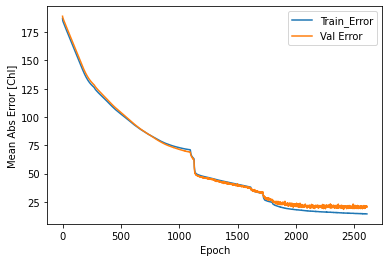

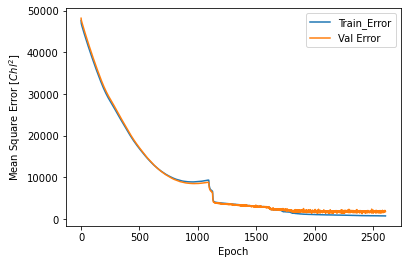

In [212]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Chl]')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train_Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label='Val Error')
    plt.legend()
   # plt.ylim([0,20])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Chl^2$]')
    plt.plot(hist['epoch'], hist['mse'],
            label='Train_Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label='Val Error')
    plt.legend()
    #plt.ylim([0,100])
    
plot_history(history)

In [213]:
loss, mae, mse = model.evaluate(scaled_test_rand, test_labels_rand, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} Chlorophyll".format(mae))

Testing set Mean Abs Error: 20.48 Chlorophyll


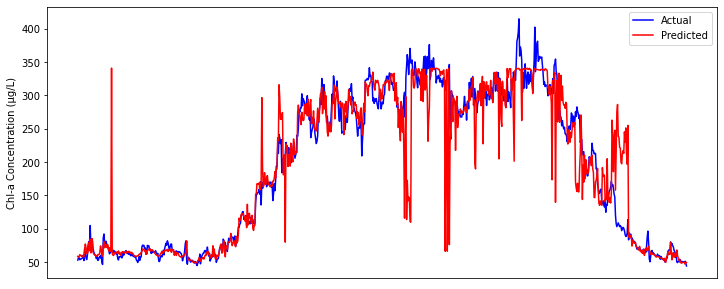

In [223]:
yhat = pd.DataFrame(model.predict(scaled_test_rand))
y_actual = pd.DataFrame(test_labels_rand)

plt.figure(figsize=(12,5))
#plt.xlabel('Actual vs Predicted Chl-a')
#plt.xticks(predicted_y, predicted_y.index.values)

plt.ylabel('Chl-a Concentration (µg/L)')

plt.plot(y_actual, color='blue', label = 'Actual')

plt.plot(yhat, color='red', label = 'Predicted')

ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.xlabel('March to April')
plt.legend()
plt.show()

In [225]:
from math import sqrt
yhat = model.predict(scaled_test_rand)
yhat_trn = model.predict(scaled_train_rand)
# calculate RMSE
rmse = sqrt(mean_squared_error(test_labels_rand, yhat))
print('Test RMSE: %.3f' % rmse)

rmse = sqrt(mean_squared_error(train_labels_rand, yhat_trn))
print('Train RMSE: %.3f' % rmse)

print('Test R2 Score: ', r2_score(test_labels_rand, yhat))

print('Train R2 Score: ', r2_score(train_labels_rand, yhat_trn))

Test RMSE: 42.399
Train RMSE: 27.203
Test R2 Score:  0.8558263030815777
Train R2 Score:  0.9415375685473534


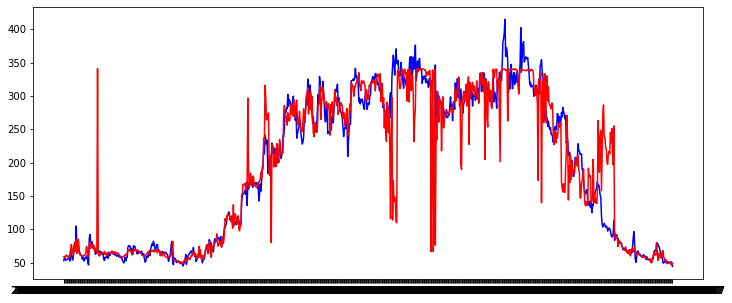

In [217]:
#Save Model for later use
#model.save('mlp_mar_apr')
# model2 = keras.models.load_model('mlp_mar_apr')

# yhat = pd.DataFrame(model2.predict(scaled_test_rand))
# y_actual = pd.DataFrame(test_labels_rand)

# plt.figure(figsize=(12,5))
# #plt.xlabel('Actual vs Predicted Chl-a')
# #plt.xticks(predicted_y, predicted_y.index.values)

# plt.plot(y_actual, color='blue')
# plt.plot(yhat, color='red')
# plt.show()